# Single-Shot CNN Denoising

We demonstrate that a deep neural net can be trained to denoise a _single_ noisy image, taking advantage of the fact that one 512 x 512 image contains ~250,000 dimensions of information.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("..")

In [3]:
from util import show, plot_images, plot_tensors

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import disk
from skimage.filters import gaussian, median
from skimage import data, img_as_float, img_as_ubyte
from skimage.color import gray2rgb
from skimage.util import random_noise
from skimage.measure import compare_psnr

In [5]:
plt.rc('figure', figsize = (5,5))

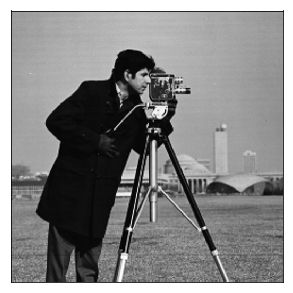

In [6]:
image = img_as_float(data.camera())
show(image)

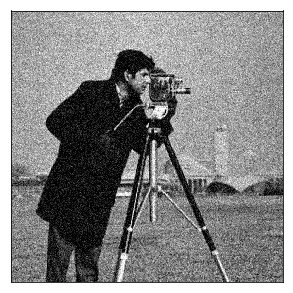

In [7]:
np.random.seed(3)
noisy_image = random_noise(image, mode = 'gaussian', var=0.01)
show(noisy_image)

In [8]:
import torch
noisy = torch.Tensor(noisy_image[np.newaxis, np.newaxis])

In [9]:
from util import getbestgpu
device = getbestgpu()

GPU device 0 has 3781 MiB left.
GPU device 1 has 734 MiB left.
GPU device 2 has 5 MiB left.
GPU device 3 has 474 MiB left.
--> GPU device 0 was chosen


# Masking

The strategy is to train a $J$-invariant version of a neural net by replacing a grid of pixels with the average of their neighbors, then only evaluating the model on the masked pixels.

In [10]:
from mask import Masker
masker = Masker(width = 4, mode='interpolate')

# Model

For our model, we use a deep convolutional network.

In [11]:
torch.manual_seed(3)
from models.dncnn import DnCNN
model = DnCNN(1, num_of_layers = 8)

In [12]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

223104

In [13]:
image.ravel().shape

(262144,)

# Training

In [14]:
from torch.nn import MSELoss, L1Loss
from torch.optim import Adam

loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.01)

In [15]:
model = model.to(device)
noisy = noisy.to(device)

In [16]:
losses = []
val_losses = []
best_images = []
best_val_loss = 1

for i in range(500):
    model.train()
    
    net_input, mask = masker.mask(noisy, i % (masker.n_masks - 1))
    net_output = model(net_input)
    
    loss = loss_function(net_output*mask, noisy*mask)
    optimizer.zero_grad()
 
    loss.backward()
    
    optimizer.step()
    
    if i % 10 == 0:
        losses.append(loss.item())
        model.eval()
        
        net_input, mask = masker.mask(noisy, masker.n_masks - 1)
        net_output = model(net_input)
    
        val_loss = loss_function(net_output*mask, noisy*mask)
        
        val_losses.append(val_loss.item())
        
        print("(", i, ") Loss: \t", round(loss.item(), 5), "\tVal Loss: \t", round(val_loss.item(), 5))

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            denoised = np.clip(model(noisy).detach().cpu().numpy()[0, 0], 0, 1).astype(np.float64)
            best_psnr = compare_psnr(denoised, image)
            best_images.append(denoised)
            print("\tModel PSNR: ", np.round(best_psnr, 2))

( 0 ) Loss: 	 0.02125 	Val Loss: 	 0.0143
	Model PSNR:  6.58
( 10 ) Loss: 	 0.00395 	Val Loss: 	 0.45602
( 20 ) Loss: 	 0.00125 	Val Loss: 	 0.01067
	Model PSNR:  7.85
( 30 ) Loss: 	 0.00092 	Val Loss: 	 0.00266
	Model PSNR:  14.4
( 40 ) Loss: 	 0.00075 	Val Loss: 	 0.00292
( 50 ) Loss: 	 0.00071 	Val Loss: 	 0.00084
	Model PSNR:  23.39
( 60 ) Loss: 	 0.00074 	Val Loss: 	 0.00073
	Model PSNR:  26.11
( 70 ) Loss: 	 0.00069 	Val Loss: 	 0.00072
	Model PSNR:  26.37
( 80 ) Loss: 	 0.00067 	Val Loss: 	 0.00073
( 90 ) Loss: 	 0.00069 	Val Loss: 	 0.00071
	Model PSNR:  26.37
( 100 ) Loss: 	 0.00066 	Val Loss: 	 0.00082
( 110 ) Loss: 	 0.00065 	Val Loss: 	 0.00078
( 120 ) Loss: 	 0.00066 	Val Loss: 	 0.00071
( 130 ) Loss: 	 0.00065 	Val Loss: 	 0.00073
( 140 ) Loss: 	 0.00064 	Val Loss: 	 0.00076
( 150 ) Loss: 	 0.00064 	Val Loss: 	 0.00065
	Model PSNR:  28.15
( 160 ) Loss: 	 0.00064 	Val Loss: 	 0.00067
( 170 ) Loss: 	 0.00063 	Val Loss: 	 0.00065
( 180 ) Loss: 	 0.00063 	Val Loss: 	 0.00064


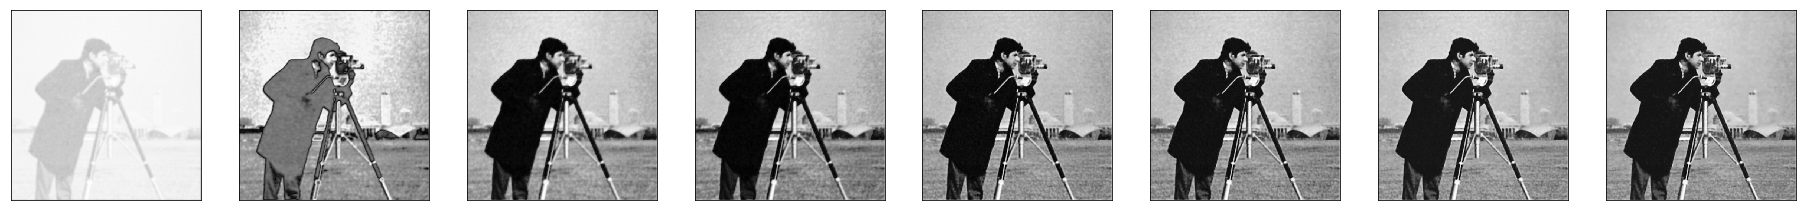

In [17]:
plot_images(best_images[::2])

In [18]:
denoised = best_images[-1]

In [19]:
compare_psnr(denoised, image)

30.292080062230315

In [20]:
inset_x_min = 100
inset_x_max = 160
inset_y_min = 230
inset_y_max = 290

get_inset = lambda x: x[inset_x_min:inset_x_max, inset_y_min:inset_y_max]

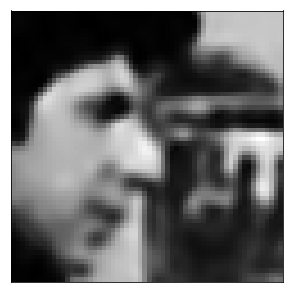

In [21]:
show(get_inset(denoised))